## Linear Regression

Equation 4-3. MSE cost function for a linear regression model  

$$
\text{MSE}(X, \theta) 
= 
\frac{1}{m} \sum_{i=1}^{m} \left( \theta^\top x^{(i)} - y^{(i)} \right)^2
$$

### The Normal Equation

To find the value of θ that minimizes the cost function, there is a closed-form solution. In other words, a mathematical equation that gives the result directly. This is called the Normal Equation (Equation 4-4).  
Equation 4-4. Normal Equation  
θ = (X<sup>⊺</sup> X)<sup>−1</sup> X<sup>⊺</sup> y  
In this equation:  
θ is the value of θ that minimizes the cost function.  
y is the vector of target values containing y(1) to y(m).  
Let’s generate some linear-looking data to test this equation on (Figure 4-1)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
m = 100 # number of instances
X = 2 * np.random.rand(m, 1) # 100 by 1 matrix of randoms (0 to 2)
y = 4 + 3 * X + np.random.randn(100, 1) # labels, last term is to add some noise

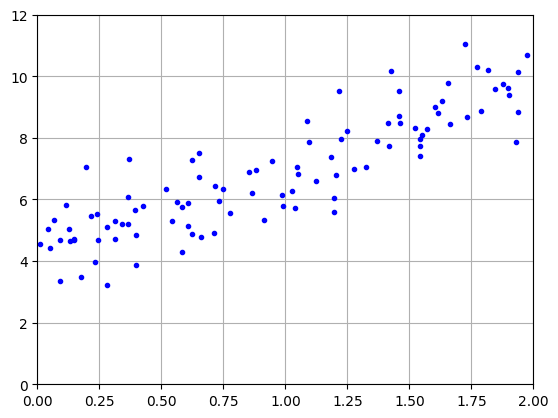

In [2]:
plt.grid()
plt.axis([0, 2, 0, 12])
plt.plot(X, y, "b.")

In [3]:
X_b = np.c_[np.ones((100, 1)), X] # x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T @ X_b) @ (X_b.T) @ (y) # @ does matrix multiplication

The function we used to calculate y values is 4 + 3 * X + random(Gaussian noise).  
Lets see what the equation found:

In [4]:
theta_best

array([[4.21509616],
       [2.77011339]])

We would have hoped for θ0 = 4 and θ1 = 3. Close enough, but the noise made it impossible to recover the exact parameters of the original function. Now lets make predictions using θ:

In [5]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2,1)), X_new]
y_predict = X_new_b @ theta_best
y_predict

array([[4.21509616],
       [9.75532293]])

Let’s plot this model’s predictions

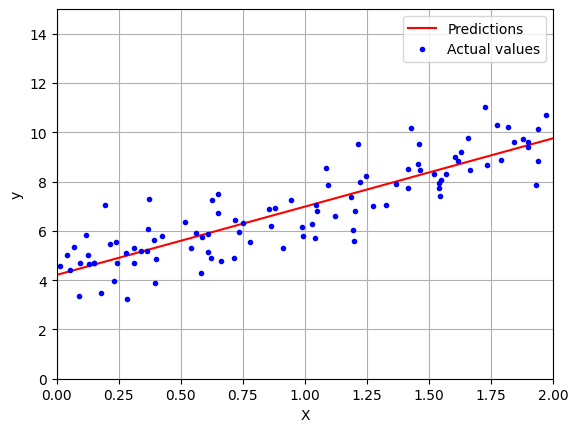

In [6]:
plt.plot(X_new, y_predict, "r-", label="Predictions")
plt.plot(X, y, "b.", label="Actual values")
plt.xlabel("X")
plt.ylabel("y")
plt.grid(True)
plt.legend()
plt.axis([0, 2, 0, 15])
plt.show()

Performing Linear Regression using Scikit-Learn is simple: 

In [7]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [8]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

The LinearRegression class is based on the scipy.linalg.lstsq() function (the
name stands for “least squares”), which you could call directly:

In [9]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

This function computes θ = X<sup>+</sup>y,  
where X<sup>+</sup> is the pseudoinverse of X (specifically, the Moore-Penrose inverse). You can use np.linalg.pinv() to compute the pseudoinverse directly:

In [10]:
np.linalg.pinv(X_b) @ y

array([[4.21509616],
       [2.77011339]])

The pseudoinverse itself is computed using a standard matrix factorization technique
called Singular Value Decomposition (SVD) that can decompose the training set
matrix X into the matrix multiplication of three matrices U Σ V⊺
(see
numpy.linalg.svd()). The pseudoinverse is computed as X+ = V Σ+ U⊺.  
To compute
the matrix Σ+, the algorithm takes Σ and sets to zero all values smaller than a tiny
threshold value, then it replaces all the nonzero values with their inverse, and finally
it transposes the resulting matrix. This approach is more efficient than computing the
Normal Equation, plus it handles edge cases nicely: indeed, the Normal Equation may
not work if the matrix X⊺X is not invertible (i.e., singular), such as if m < n or if some
features are redundant, but the pseudoinverse is always defined.


Computational Complexity  
The Normal Equation computes the inverse of X⊺ X, which is an (n + 1) × (n + 1) matrix (where n is the number of features). The computational complexity of inverting such a matrix is typically about O(n<sup>2.4</sup>) to O(n<sup>3</sup>), depending on the implementation. In other words, if you double the number of features, you multiply the computation time by roughly 2<sup>2.4</sup> = 5.3 to 2<sup>3</sup> = 8.
The SVD approach used by Scikit-Learn’s LinearRegression class is about O(n<sup>2</sup>). If you double the number of features, you multiply the computation time by roughly 4.

Note:  
Both the Normal Equation and the SVD approach get very slow
when the number of features grows large (e.g., 100,000). On the
positive side, both are linear with regard to the number of instances
in the training set (they are O(m)), so they handle large training
sets efficiently, provided they can fit in memory.

Also, once you have trained your Linear Regression model (using the Normal Equation or any other algorithm), predictions are very fast: the computational complexity
is linear with regard to both the number of instances you want to make predictions
on and the number of features. In other words, making predictions on twice as many
instances (or twice as many features) will take roughly twice as much time.
Now we will look at a very different way to train a Linear Regression model, which is
better suited for cases where there are a large number of features or too many training
instances to fit in memory.

## Gradient Descent

Fortunately, the MSE cost function for a linear regression model happens to be a
convex function, which means that if you pick any two points on the curve, the line
segment joining them is never below the curve. This implies that there are no local
minima, just one global minimum. It is also a continuous function with a slope that
never changes abruptly.
These two facts have a great consequence: gradient descent
is guaranteed to approach arbitrarily closely the global minimum (if you wait long
enough and if the learning rate is not too high).  

While the cost function has the shape of a bowl, it can be an elongated bowl if the
features have very different scales. Figure 4-7 shows gradient descent on a training set
where features 1 and 2 have the same scale (on the left), and on a training set where
feature 1 has much smaller values than feature 2 (on the right).

As you can see, on the left the gradient descent algorithm goes straight toward the
minimum, thereby reaching it quickly, whereas on the right it first goes in a direction
almost orthogonal to the direction of the global minimum, and it ends with a long
march down an almost flat valley. It will eventually reach the minimum, but it will
take a long time.  

When using gradient descent, you should ensure that all features
have a similar scale (e.g., using Scikit-Learn’s StandardScaler
class), or else it will take much longer to converge.  

This diagram also illustrates the fact that training a model means searching for a
combination of model parameters that minimizes a cost function (over the training
set). It is a search in the model’s parameter space. The more parameters a model
has, the more dimensions this space has, and the harder the search is: searching
for a needle in a 300-dimensional haystack is much trickier than in 3 dimensions.
Fortunately, since the cost function is convex in the case of linear regression, the
needle is simply at the bottom of the bowl.


### Batch Gradient Descent  

To implement gradient descent, you need to compute the gradient of the cost function with regard to each model parameter θj
. In other words, you need to calculate
how much the cost function will change if you change θj
just a little bit. This is called
a partial derivative. It is like asking, “What is the slope of the mountain under my
feet if I face east”? and then asking the same question facing north (and so on for all
other dimensions, if you can imagine a universe with more than three dimensions).
Equation 4-5 computes the partial derivative of the MSE with regard to parameter θj
,
noted ∂ MSE(θ) / ∂θj.  

$$
\text{MSE}(\theta) 
= 
\frac{1}{m} \sum_{i=1}^{m} \left( \theta^\top x^{(i)} - y^{(i)} \right)^2
$$

$$
\frac{\partial}{\partial \theta_j} \mathrm{MSE}(\theta)
=
\frac{2}{m}
\sum_{i=1}^{m}
\left( \theta^{\top} x^{(i)} - y^{(i)} \right) x_j^{(i)}
$$

Instead of computing these partial derivatives individually, you can use Equation 4-6
to compute them all in one go. The gradient vector, noted $\nabla_\theta \text{MSE}(\theta)$, contains all the
partial derivatives of the cost function (one for each model parameter).

Equation 4-6. Gradient vector of the cost function

$$
\nabla_\theta \text{MSE}(\theta) =
\begin{bmatrix}
\frac{\partial}{\partial \theta_0} \text{MSE}(\theta) \\
\frac{\partial}{\partial \theta_1} \text{MSE}(\theta) \\
\vdots \\
\frac{\partial}{\partial \theta_n} \text{MSE}(\theta)
\end{bmatrix}
=
\frac{2}{m} X^\top (X \theta - y)
$$

Notice that this formula involves calculations over the full training
set $X$ at each gradient descent step. This is why the algorithm is called batch gradient descent: it uses the whole batch of training
data at every step (actually, full gradient descent would probably
be a better name). As a result, it is terribly slow on very large
training sets (we will look at some much faster gradient descent
algorithms shortly). However, gradient descent scales well with the
number of features; training a linear regression model when there
are hundreds of thousands of features is much faster using gradient
descent than using the Normal equation or SVD decomposition.  

Simple Summary:  
At each step, it calculates partial derivatives with respect to each model parameter (which is equal to the number of features) using the whole training set.  

- If the training set size increases (say doubles), it takes double the time at each step.  
- If the number of features increases, the computation time per step increases linearly with the number of features, because we need to compute a partial derivative for each feature.  

In other words, batch gradient descent is sensitive to dataset size, but scales relatively well with the number of features.

Once you have the gradient vector, which points uphill, just go in the opposite
direction to go downhill. This means subtracting $\nabla_\theta \text{MSE}(\theta)$ from $\theta$. This is where the learning rate $\eta$ comes into play: multiply the gradient vector by $\eta$ to determine the
size of the downhill step (Equation 4-7).

Equation 4-7. Gradient descent step

$$
\theta_{\text{next step}} = \theta - \eta \nabla_\theta \text{MSE}(\theta)
$$

Let’s look at a quick implementation of this algorithm:


In [11]:
eta = 0.1 # learning rate hyperparameter
n_epochs = 1000
m = len(X_b)

np.random.seed(42)
theta = np.random.randn(2, 1) # random initial model parameter

for epoch in range(n_epochs):
    gradients = 2 / m * X_b.T @ (X_b @ theta - y)
    theta = theta - eta * gradients

In [12]:
theta

array([[4.21509616],
       [2.77011339]])

Hey, that’s exactly what the Normal equation found! Gradient descent worked per‐
fectly. But what if you had used a different learning rate (eta)? Figure 4-8 shows
the first 20 steps of gradient descent using three different learning rates. The line
at the bottom of each plot represents the random starting point, then each epoch is
represented by a darker and darker line.  

To find a good learning rate, you can use grid search (see Chapter 2). However, you
may want to limit the number of epochs so that grid search can eliminate models that
take too long to converge.  

You may wonder how to set the number of epochs. If it is too low, you will still be
far away from the optimal solution when the algorithm stops; but if it is too high,
you will waste time while the model parameters do not change anymore. A simple
solution is to set a very large number of epochs but to interrupt the algorithm when
the gradient vector becomes tiny—that is, when its norm becomes smaller than a
tiny number ϵ (called the tolerance)—because this happens when gradient descent has
(almost) reached the minimum.

Convergence Rate  

When the cost function is convex and its slope does not change abruptly (as is the
case for the MSE cost function), batch gradient descent with a fixed learning rate will
eventually converge to the optimal solution, but you may have to wait a while: it can
take O(1/ϵ) iterations to reach the optimum within a range of ϵ, depending on the
shape of the cost function. If you divide the tolerance by 10 to have a more precise
solution, then the algorithm may have to run about 10 times longer

### Stochastic Gradient Descent 

The main problem with batch gradient descent is the fact that it uses the whole
training set to compute the gradients at every step, which makes it very slow when
the training set is large. At the opposite extreme, stochastic gradient descent picks a
random instance in the training set at every step and computes the gradients based
only on that single instance. Obviously, working on a single instance at a time makes
the algorithm much faster because it has very little data to manipulate at every
iteration. It also makes it possible to train on huge training sets, since only one
instance needs to be in memory at each iteration (stochastic GD can be implemented
as an out-of-core algorithm; see Chapter 1).  

On the other hand, due to its stochastic (i.e., random) nature, this algorithm is
much less regular than batch gradient descent: instead of gently decreasing until it
reaches the minimum, the cost function will bounce up and down, decreasing only
on average. Over time it will end up very close to the minimum, but once it gets there
it will continue to bounce around, never settling down (see Figure 4-9). Once the
algorithm stops, the final parameter values will be good, but not optimal.  

When the cost function is very irregular (as in Figure 4-6), this can actually help
the algorithm jump out of local minima, so stochastic gradient descent has a better
chance of finding the global minimum than batch gradient descent does.  

Therefore, randomness is good to escape from local optima, but bad because it means
that the algorithm can never settle at the minimum. One solution to this dilemma
is to gradually reduce the learning rate. The steps start out large (which helps make
quick progress and escape local minima), then get smaller and smaller, allowing
the algorithm to settle at the global minimum. This process is akin to simulated
annealing, an algorithm inspired by the process in metallurgy of annealing, where
molten metal is slowly cooled down. The function that determines the learning rate at each iteration is called the learning schedule. If the learning rate is reduced too
quickly, you may get stuck in a local minimum, or even end up frozen halfway to
the minimum. If the learning rate is reduced too slowly, you may jump around the
minimum for a long time and end up with a suboptimal solution if you halt training
too early.  

This code implements stochastic gradient descent using a simple learning schedule:

In [13]:
n_epochs = 50
t0, t1 = 5, 50 # learning schedule hyperparameters
m = len(X_b)

def learning_schedule(t):
    return t0 / (t + t1)

np.random.seed(42)
theta = np.random.randn(2, 1) 

for epoch in range(n_epochs):
    for iteration in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index : random_index + 1]
        yi = y[random_index : random_index + 1]
        gradients = 2 * xi.T @ (xi @ theta - yi) # for SGD do not divide by m
        eta = learning_schedule(epoch * m + iteration)
        theta = theta - eta * gradients

While the batch gradient descent code iterated 1,000 times through the whole
training set, this code goes through the training set only 50 times and reaches a pretty
good solution:

In [14]:
theta

array([[4.21076011],
       [2.74856079]])

To perform linear regression using stochastic GD with Scikit-Learn, you can use
the SGDRegressor class, which defaults to optimizing the MSE cost function. The
following code runs for maximum 1,000 epochs (max_iter) or until the loss drops by
less than 10–5 (tol) during 100 epochs (n_iter_no_change). It starts with a learning
rate of 0.01 (eta0), using the default learning schedule (different from the one we
used). Lastly, it does not use any regularization (penalty=None; more details on this
shortly):

In [15]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-5, penalty=None, eta0=0.01, n_iter_no_change=100, random_state=42)
sgd_reg.fit(X, y.ravel())

,loss,'squared_error'
,penalty,None
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,1e-05
,shuffle,True
,verbose,0
,epsilon,0.1
,random_state,42


In [16]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.21278812]), array([2.77270267]))

### Mini-Batch Gradient Descent 

The last gradient descent algorithm we will look at is called mini-batch gradient
descent. It is straightforward once you know batch and stochastic gradient descent:
at each step, instead of computing the gradients based on the full training set (as in
batch GD) or based on just one instance (as in stochastic GD), mini-batch GD com‐
putes the gradients on small random sets of instances called mini-batches. The main
advantage of mini-batch GD over stochastic GD is that you can get a performance
boost from hardware optimization of matrix operations, especially when using GPUs.

Comparison:  

| Algorithm        | Large m | Out-of-core support | Large n | Hyperparams | Scaling required | Scikit-Learn       |
|-----------------|---------|-------------------|---------|------------|----------------|------------------|
| Normal equation  | Fast    | No                | Slow    | 0          | No             | N/A              |
| SVD              | Fast    | No                | Slow    | 0          | No             | LinearRegression |
| Batch GD         | Slow    | No                | Fast    | 2          | Yes            | N/A              |
| Stochastic GD    | Fast    | Yes               | Fast    | ≥2         | Yes            | SGDRegressor     |
| Mini-batch GD    | Fast    | Yes               | Fast    | ≥2         | Yes            | N/A              |

## Polynomial Regression

What if your data is more complex than a straight line? Surprisingly, you can use a
linear model to fit nonlinear data. A simple way to do this is to add powers of each
feature as new features, then train a linear model on this extended set of features. This
technique is called polynomial regression  

Let’s look at an example. First, we’ll generate some nonlinear data (see Figure 4-12),
based on a simple quadratic equation—that’s an equation of the form y = ax² + bx +
c—plus some noise:  

In [17]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)

Text(0, 0.5, 'y')

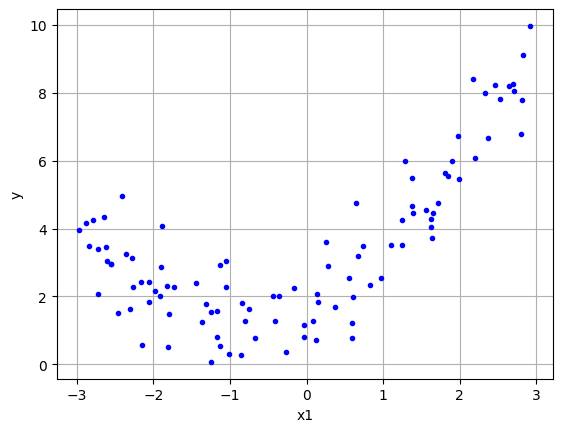

In [18]:
plt.grid()
plt.plot(X, y, "b.")
plt.xlabel("x1")
plt.ylabel("y")

Clearly, a straight line will never fit this data properly. So let’s use Scikit-Learn’s
PolynomialFeatures class to transform our training data, adding the square (second degree polynomial) of each feature in the training set as a new feature (in this case
there is just one feature):

In [19]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
print(X[0]) # original
print(X_poly[0]) # original and its square

[-0.75275929]
[-0.75275929  0.56664654]


Now we can fit a LinearRegression model to this extended training data

In [20]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

Not bad: the model estimates y = 0.56x1<sup>2</sup>+ 0.93x1 + 1.78 when in fact the original function was y = 0.5x1<sup>2</sup>+ 1.0x1 + 2.0 + Gaussian noise.
Note that when there are multiple features, polynomial regression is capable of
finding relationships between features, which is something a plain linear regression
model cannot do. This is made possible by the fact that PolynomialFeatures also
adds all combinations of features up to the given degree. For example, if there were
two features a and b, PolynomialFeatures with degree=3 would not only add the
features a
2
, a
3
, b
2
, and b
3
, but also the combinations ab, a
2b, and ab2
.

In [21]:
y_predict = lin_reg.predict(X_poly)

In [22]:
sorted_idx = np.argsort(X.ravel())

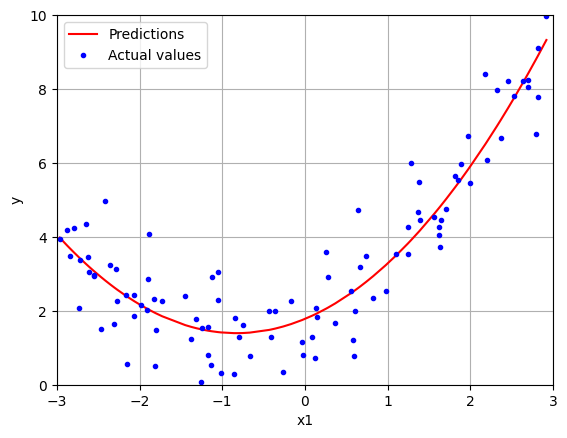

In [23]:
plt.plot(X[sorted_idx], y_predict[sorted_idx], "r-", label="Predictions")
plt.plot(X[sorted_idx], y[sorted_idx], "b.", label="Actual values")
plt.xlabel("x1")
plt.ylabel("y")
plt.axis([-3, 3, 0, 10])
plt.grid(True)
plt.legend()
plt.show()

## Learning Curves

Scikit-Learn has a useful learning_curve() function to help with this: it trains
and evaluates the model using cross-validation. By default it retrains the model on
growing subsets of the training set, but if the model supports incremental learning
you can set exploit_incremental_learning=True when calling learning_curve()
and it will train the model incrementally instead. The function returns the training
set sizes at which it evaluated the model, and the training and validation scores it measured for each size and for each cross-validation fold. Let’s use this function to
look at the learning curves of the plain linear regression model (see Figure 4-15):

In [24]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    LinearRegression(), X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5, 
    scoring="neg_root_mean_squared_error")

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

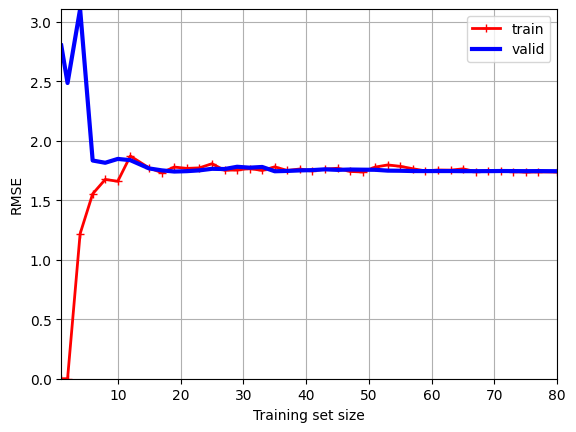

In [25]:
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.grid()
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.margins(0)
plt.legend()

These learning curves are typical of a model that’s underfitting. Both curves have
reached a plateau; they are close and fairly high

Now let’s look at the learning curves of a 10th-degree polynomial model on the same
data (Figure 4-16):


In [26]:
from sklearn.pipeline import make_pipeline

polynomial_regression = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    LinearRegression()
)

train_sizes, train_scores, valid_scores = learning_curve(
    polynomial_regression, X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error"
)

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

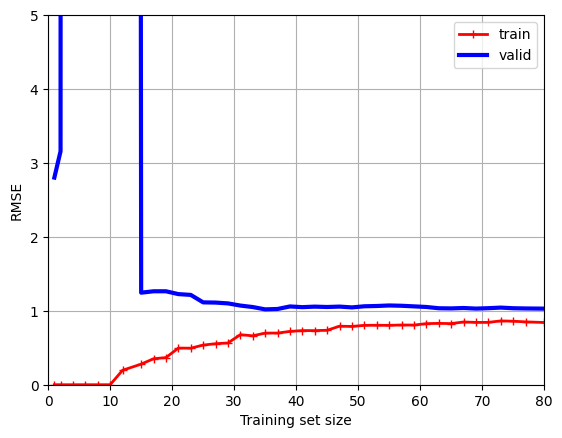

In [27]:
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.grid()
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.axis([0, 80, 0, 5])
plt.legend()

These learning curves look a bit like the previous ones, but there are two very
important differences:  
• The error on the training data is much lower than before.  
• There is a gap between the curves. This means that the model performs significantly better on the training data than on the validation data, which is the hallmark of an overfitting model. If you used a much larger training set, however,
the two curves would continue to get closer.


Let's test  with degree 2

In [28]:
polynomial_regression = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    LinearRegression()
)

train_sizes, train_scores, valid_scores = learning_curve(
    polynomial_regression, X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error"
)

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

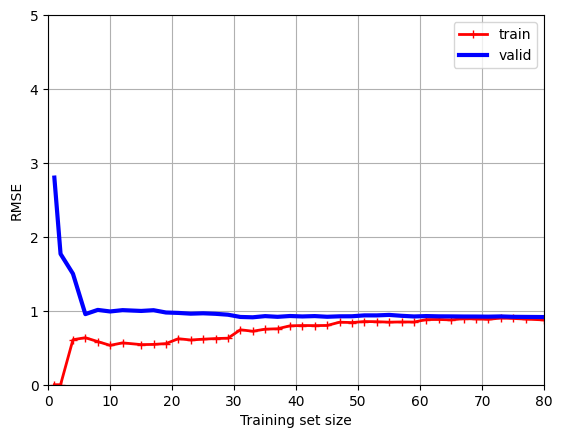

In [29]:
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.grid()
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.axis([0, 80, 0, 5])
plt.legend()

Compared to linear which gave arounf 1.75 for both(underfitting), and degree 10 which gave around 1.05 for validation and 0.85 for training(overfitting) this one gives around 0.95 for validation and 0.90 for training seems to be the perfect balance.

## Regularized Linear Models

### Ridge Regression (Tikhonov Regularization)

Ridge regression (also called **Tikhonov regularization**) is a regularized version of linear regression.

A regularization term equal to:

$$
\frac{\alpha}{m} \sum_{i=1}^{n} \theta_i^2
$$

is added to the Mean Squared Error (MSE). This forces the learning algorithm to:

- Fit the data
- Keep the model weights as small as possible

> ⚠️ The regularization term is added **only during training**.  
> After training, use the **unregularized MSE (or RMSE)** to evaluate performance.

---

#### Hyperparameter α (Alpha)

- If **α = 0** → Ridge regression becomes standard linear regression.
- If **α is very large** → All weights shrink close to 0, resulting in a flat line near the data’s mean.

---

#### Ridge Regression Cost Function

$$
J(\theta) = \text{MSE}(\theta) + \frac{\alpha}{m} \sum_{i=1}^{n} \theta_i^2
$$


Here is how to perform ridge regression with Scikit-Learn using a closed-form
solution

In [30]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=0.1 / m, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([4.8294419])

Now using SGD.

In [31]:
sgd_reg = SGDRegressor(penalty="l2", alpha=0.1 / m, tol=None,
                       max_iter=1000, eta0=0.01, random_state=42)

sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([4.82830117])

The penalty hyperparameter sets the type of regularization term to use. Specifying
"l2" indicates that you want SGD to add a regularization term to the MSE cost
function equal to alpha times the square of the ℓ2
 norm of the weight vector. This is
just like ridge regression, except there’s no division by m in this case; that’s why we
passed alpha=0.1 / m, to get the same result as Ridge(alpha=0.1).

### Lasso Regression

Least Absolute Shrinkage and Selection Operator regression (usually simply called **Lasso regression**) is another regularized version of linear regression. Just like ridge regression, it adds a regularization term to the cost function, but it uses the **ℓ1 norm** of the weight vector instead of the square of the ℓ2 norm.

Notice that the ℓ1 norm is multiplied by `2α`, whereas the ℓ2 norm was multiplied by `α / m` in ridge regression. These factors were chosen to ensure that the optimal α value is independent of the training set size. Different norms lead to different factors.

Lasso Regression Cost Function

$$
J(\theta) = \text{MSE}(\theta) + 2 \alpha \sum_{i=1}^{n} |\theta_i|
$$


Here is a small Scikit-Learn example using the Lasso class:

In [32]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([4.77621741])

In [33]:
sgd_reg = SGDRegressor(penalty="l1", alpha=0.1, tol=None,
                       max_iter=1000, eta0=0.01, random_state=42)

sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([4.77557733])

### Elastic Net Regression

Elastic net regression is a middle ground between **ridge regression** and **lasso regression**. The regularization term is a weighted sum of both ridge and lasso’s regularization terms, and you can control the **mix ratio** \(r\).  

- When \(r = 0\), elastic net is equivalent to ridge regression.  
- When \(r = 1\), it is equivalent to lasso regression (Equation 4-12).

Equation 4-12. Elastic Net Cost Function

$$
J(\theta) = \text{MSE}(\theta) + r \, 2 \alpha \sum_{i=1}^{n} |\theta_i| + (1-r) \frac{\alpha}{m} \sum_{i=1}^{n} \theta_i^2
$$

---

When to use Elastic Net, Ridge, Lasso, or Plain Linear Regression

- It is almost always preferable to have at least a little bit of regularization, so generally you should **avoid plain linear regression**.  
- **Ridge** is a good default.  
- If you suspect that **only a few features are useful**, prefer **lasso** or **elastic net** because they tend to reduce the weights of useless features down to zero.  
- In general, **elastic net is preferred over lasso** because lasso may behave erratically when:  
  1. The number of features is greater than the number of training instances.  
  2. Several features are strongly correlated.

Here is a short example that uses Scikit-Learn’s ElasticNet (l1_ratio corresponds to
the mix ratio r):

In [34]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([4.78114505])

### Early Stopping

A very different way to regularize iterative learning algorithms such as gradient
descent is to stop training as soon as the validation error reaches a minimum. This is
called early stopping. Figure 4-20 shows a complex model (in this case, a high-degree
polynomial regression model) being trained with batch gradient descent on the
quadratic dataset we used earlier. As the epochs go by, the algorithm learns, and its
prediction error (RMSE) on the training set goes down, along with its prediction
error on the validation set. After a while, though, the validation error stops decreas‐
ing and starts to go back up. This indicates that the model has started to overfit the
training data. With early stopping you just stop training as soon as the validation
error reaches the minimum. It is such a simple and efficient regularization technique
that Geoffrey Hinton called it a “beautiful free lunch”.

Here is a basic implementation of early stopping:  
This code first adds the polynomial features and scales all the input features, both
for the training set and for the validation set (the code assumes that you have split
the original training set into a smaller training set and a validation set). Then it
creates an SGDRegressor model with no regularization and a small learning rate. In
the training loop, it calls partial_fit() instead of fit(), to perform incremental
learning. At each epoch, it measures the RMSE on the validation set. If it is lower
than the lowest RMSE seen so far, it saves a copy of the model in the best_model
variable. This implementation does not actually stop training, but it lets you revert to
the best model after training. Note that the model is copied using copy.deepcopy(),
because it copies both the model’s hyperparameters and the learned parameters. In
contrast, sklearn.base.clone() only copies the model’s hyperparameters.


In [35]:
from copy import deepcopy
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler

X_train, y_train, X_valid, y_valid = X[:80], y[:80], X[80:], y[80:]

preprocessing = make_pipeline(PolynomialFeatures(degree=90, include_bias=False),
                              StandardScaler())

X_train_prep = preprocessing.fit_transform(X_train)
X_valid_prep = preprocessing.transform(X_valid)

sgd_reg = SGDRegressor(penalty=None, eta0=0.002, random_state=42)
n_epochs = 1000
best_valid_rmse = float('inf')

for epoch in range(n_epochs):
    sgd_reg.partial_fit(X_train_prep, y_train.ravel())
    y_valid_predict = sgd_reg.predict(X_valid_prep)
    val_error = root_mean_squared_error(y_valid, y_valid_predict)
    if val_error < best_valid_rmse:
        best_valid_rmse = val_error
        best_model = deepcopy(sgd_reg)

In [36]:
root_mean_squared_error(best_model.predict(X_valid_prep), y_valid)

0.9762221918239441

## Logistic Regression 

As discussed in Chapter 1, some regression algorithms can be used for classification
(and vice versa). Logistic regression (also called logit regression) is commonly used to
estimate the probability that an instance belongs to a particular class (e.g., what is
the probability that this email is spam?). If the estimated probability is greater than a
given threshold (typically 50%), then the model predicts that the instance belongs to
that class (called the positive class, labeled “1”), and otherwise it predicts that it does
not (i.e., it belongs to the negative class, labeled “0”). This makes it a binary classifier

### Estimating Probabilities

So how does logistic regression work? Just like a linear regression model, a logistic regression model computes a weighted sum of the input features (plus a bias term), but instead of outputting the result directly like the linear regression model does, it outputs the logistic of this result (see Equation 4-13).

**Equation 4-13. Logistic regression model estimated probability (vectorized form)**

$$
p = h_\theta(x) = \sigma(\theta^\top x)
$$

The logistic—noted $\sigma(\cdot)$ —is a sigmoid function (i.e., S-shaped) that outputs a number between 0 and 1. It is defined as shown in Equation 4-14 and Figure 4-21.

**Equation 4-14. Logistic function**

$$
\sigma(t) = \frac{1}{1 + \exp(-t)}
$$

Once the logistic regression model has estimated the probability 

$$
p = h_\theta(x)
$$

that an instance \(x\) belongs to the positive class, it can make its prediction $\hat{y}$ easily (see Equation 4-15).

**Equation 4-15. Logistic regression model prediction using a 50% threshold probability**

$$
y =
\begin{cases} 
0 & \text{if } p < 0.5 \\ 
1 & \text{if } p \ge 0.5 
\end{cases}
$$

Notice that $\sigma(t) < 0.5$ when $t < 0$, and $\sigma(t) \ge 0.5$ when $t \ge 0$, so a logistic regression model using the default threshold of 50% probability predicts 1 if $\theta^\top x$ is positive and 0 if it is negative.



### Training and Cost Function

Now you know how a logistic regression model estimates probabilities and makes predictions. But how is it trained? The objective of training is to set the parameter vector $\theta$ so that the model estimates high probabilities for positive instances ($y = 1$) and low probabilities for negative instances ($y = 0$). This idea is captured by the cost function shown in Equation 4-16 for a single training instance $x$.

**Equation 4-16. Cost function of a single training instance**

$$
c_\theta =
\begin{cases} 
-\log p & \text{if } y = 1 \\
-\log (1 - p) & \text{if } y = 0
\end{cases}
$$

This cost function makes sense because $-\log(t)$ grows very large when $t$ approaches 0, so the cost will be large if the model estimates a probability close to 0 for a positive instance, and it will also be large if the model estimates a probability close to 1 for a negative instance. On the other hand, $-\log(t)$ is close to 0 when $t$ is close to 1, so the cost will be close to 0 if the estimated probability is close to 0 for a negative instance or close to 1 for a positive instance, which is precisely what we want.

The cost function over the whole training set is the average cost over all training instances. It can be written in a single expression called the **log loss**, shown in Equation 4-17.

**Equation 4-17. Logistic regression cost function (log loss)**

$$
J(\theta) = -\frac{1}{m} \sum_{i=1}^{m} \Big[ y_i \log p_i + (1 - y_i) \log (1 - p_i) \Big]
$$


The bad news is that there is no known closed-form equation to compute the value of $\theta$ that minimizes this cost function (there is no equivalent of the Normal equation). But the good news is that this cost function is convex, so gradient descent (or any other optimization algorithm) is guaranteed to find the global minimum (if the learning rate is not too large and you wait long enough). The partial derivatives of the cost function with regard to the $j$th model parameter $\theta_j$ are given by Equation 4-18.

**Equation 4-18. Logistic cost function partial derivatives**

$$
\frac{\partial}{\partial \theta_j} J(\theta) = \frac{1}{m} \sum_{i=1}^{m} (\sigma(\theta^\top x_i) - y_i) x_j^i
$$

This equation looks very much like Equation 4-5: for each instance it computes the prediction error and multiplies it by the jth feature value, and then it computes the average over all training instances. Once you have the gradient vector containing all the partial derivatives, you can use it in the batch gradient descent algorithm.  

That’s it: you now know how to train a logistic regression model. For stochastic GD you would take one instance at a time, and for mini-batch GD you would use a mini-batch at a time.


### Decision Boundaries

We can use the iris dataset to illustrate logistic regression. This is a famous dataset
that contains the sepal and petal length and width of 150 iris flowers of three different
species: Iris setosa, Iris versicolor, and Iris virginica.  

Let’s try to build a classifier to detect the Iris virginica type based only on the petal
width feature. The first step is to load the data and take a quick peek:

In [37]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)

In [38]:
iris.data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [39]:
iris.target.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [40]:

iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = iris.data[["petal width (cm)"]].values
y = iris.target_names[iris.target] == 'virginica'
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


Let’s look at the model’s estimated probabilities for flowers with petal widths varying
from 0 cm to 3 cm 

In [42]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundry = X_new[y_proba[:, 1] >= 0.5][0, 0]

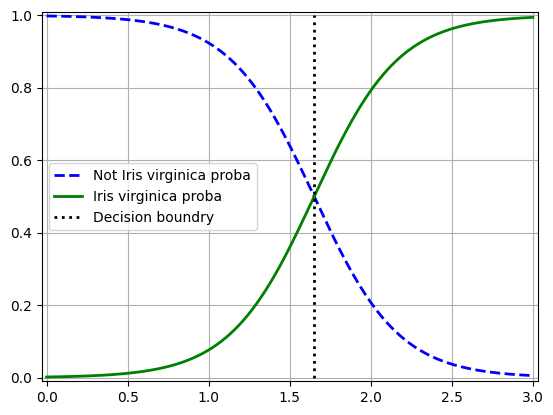

In [43]:
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2,
         label="Not Iris virginica proba")
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2,
         label="Iris virginica proba")
plt.plot([decision_boundry, decision_boundry], [0, 1], "k:", linewidth=2,
         label="Decision boundry")
plt.grid()
plt.legend()
plt.margins(0.01)


### Softmax Regression



The logistic regression model can be generalized to support multiple classes directly,
without having to train and combine multiple binary classifiers (as discussed in
Chapter 3). This is called softmax regression, or multinomial logistic regression.  
The idea is simple: when given an instance x, the softmax regression model first
computes a score sk
(x) for each class k, then estimates the probability of each class by
applying the softmax function (also called the normalized exponential) to the scores.
The equation to compute sk
(x) should look familiar, as it is just like the equation for
linear regression prediction.

Equation 4-19. Softmax score for class $k$

$$
s_k(\mathbf{x}) = \theta_k^\top \mathbf{x}
$$

Note that each class has its own dedicated parameter vector $\theta^{(k)}$.  
All these vectors are typically stored as rows in a parameter matrix $\Theta$.

Once you have computed the score of every class for the instance $\mathbf{x}$, you can estimate the probability $p_k$ that the instance belongs to class $k$ by running the scores through the softmax function (Equation 4-20). The function computes the exponential of every score, then normalizes them (dividing by the sum of all the exponentials). The scores are generally called logits or log-odds (although they are actually unnormalized log-odds).

Equation 4-20. Softmax function

$$
p_k = \sigma(\mathbf{s}(\mathbf{x}))_k =
\frac{\exp\left(s_k(\mathbf{x})\right)}
{\sum_{j=1}^{K} \exp\left(s_j(\mathbf{x})\right)}
$$

Just like the logistic regression classifier, by default the softmax regression classifier predicts the class with the highest estimated probability (which is simply the class with the highest score), as shown in Equation 4-21.

Equation 4-21. Softmax regression classifier prediction

$$
\hat{y} = \arg\max_k \sigma(\mathbf{s}(\mathbf{x}))_k
= \arg\max_k s_k(\mathbf{x})
= \arg\max_k \theta^{(k)\top} \mathbf{x}
$$

The $\arg\max$ operator returns the value of a variable that maximizes a function. In this equation, it returns the value of $k$ that maximizes the estimated probability $\sigma(\mathbf{s}(\mathbf{x}))_k$.

Now that you know how the model estimates probabilities and makes predictions, let’s take a look at training. The objective is to have a model that estimates a high probability for the target class (and consequently a low probability for the other classes). Minimizing the cost function shown in Equation 4-22, called the cross entropy, should lead to this objective because it penalizes the model when it estimates a low probability for a target class. Cross entropy is frequently used to measure how well a set of estimated class probabilities matches the target classes.

Equation 4-22. Cross entropy cost function

$$
J(\Theta) =
- \frac{1}{m}
\sum_{i=1}^{m}
\sum_{k=1}^{K}
y_k^{(i)} \log \left( p_k^{(i)} \right)
$$

In this equation, $y_k^{(i)}$ is the target probability that the $i$th instance belongs to class $k$. In general, it is either equal to 1 or 0, depending on whether the instance belongs to the class or not.

Notice that when there are just two classes ($K = 2$), this cost function is equivalent to the logistic regression cost function.

The gradient vector of this cost function with regard to $\theta^{(k)}$ is given by Equation 4-23.

Equation 4-23. Cross entropy gradient vector for class $k$

$$
\nabla_{\theta^{(k)}} J(\Theta)
=
\frac{1}{m}
\sum_{i=1}^{m}
\left( p_k^{(i)} - y_k^{(i)} \right)
\mathbf{x}^{(i)}
$$

Now you can compute the gradient vector for every class, then use gradient descent (or any other optimization algorithm) to find the parameter matrix $\Theta$ that minimizes the cost function.

Let’s use softmax regression to classify the iris plants into all three classes. Scikit-Learn’s `LogisticRegression` classifier uses softmax regression automatically when you train it on more than two classes (assuming you use `solver="lbfgs"`, which is the default). It also applies $\ell_2$ regularization by default, which you can control using the hyperparameter $C$, as mentioned earlier.

In [71]:
X = iris["data"]
y = iris["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

softmax_reg = LogisticRegression(C=30, random_state=42)
softmax_reg.fit(X_train, y_train)


d:\programming\machine_learning\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,30
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [72]:
softmax_reg.predict([[5, 3, 1, 0.3]])

d:\programming\machine_learning\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([0])

In [73]:
softmax_reg.predict_proba([[5.1, 3.5, 1.4, 0.2]])

d:\programming\machine_learning\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([[9.97654830e-01, 2.34517017e-03, 1.37475044e-17]])

In [74]:
from sklearn.metrics import accuracy_score

y_pred = softmax_reg.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
accuracy

1.0